In [1]:
# Install langdetect
!pip install langdetect

     |████████████████████████████████| 981 kB 922 kB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=ccabbdbfb4e2a40d8dde72ebbfbc7df4cb7a39055fd9ede4098bc1ed398f74d4
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### 1. Import Packages

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import pickle

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, precision_score,recall_score, precision_recall_fscore_support, cohen_kappa_score

from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, plot_confusion_matrix

from imblearn.over_sampling import SMOTE

from langdetect import detect

import matplotlib.pyplot as plt

from tabulate import tabulate

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2. Data Selection

In [3]:
# Read the Input Data
data = pd.read_csv('../input/coursera-customer-reviews/reviews_by_course.csv', names=["courseid", "review", "label"], header=0, dtype={'label':'str'})

print(data.head())

     courseid                                             review label
0  2-speed-it                                             BOring     1
1  2-speed-it                                            Bravo !     5
2  2-speed-it                                           Very goo     5
3      2d-cad                                         简单易懂，实用性很强     5
4  2-speed-it  Great course - I recommend it for all, especia...     5


### 3. Exploratory Data Analysis

In [4]:
# Describe the data   
print('\n Total number of data objects:             ', len(data))
print('\n Total number of attributes:                    ', len(data.columns))
print('\n Total number of values:                   ', len(data)*len(data.columns))
print('\n Total number of duplicates data objects:    ', len(data)-len(data.drop_duplicates()))
print('\n Total number of missing values:                ', data.isnull().sum().sum())
data.describe()


 Total number of data objects:              140320

 Total number of attributes:                     3

 Total number of values:                    420960

 Total number of duplicates data objects:     3016

 Total number of missing values:                 3


,courseid,review,label
count,140320,140317,140320
unique,1835,123239,5
top,machine-learning,Great course!,5
freq,8570,509,106516


### 4. Data Cleaning

In [5]:
#Remove Duplicate Records
data.drop_duplicates(inplace=True)

# Remove records with missing values
data = data.dropna()

# Remove records with numeric values
data = data.drop(data[data['review'].str.isnumeric()].index) 

# Resets the index in the dataframe
data = data.reset_index(drop=True)

### 5. Data Preprocessing

In [6]:
def preprocess_data(review_data):
    ps = PorterStemmer()
    
    preprocessed_review = []
    preprocessed_label  = []
    
    for i in range(1, len(review_data)):
        # Remove Noisy Data
        review = re.sub('[^a-zA-Z\\s]', '', review_data[i]).strip()
        
        # Remove Non-english Reviews
        if(len(review) == 0 or len(review) == 1 or detect(review) == "vi" or  detect(review) == "ko" or detect(review) == "ru" or detect(review) == "zh-cn"):
          continue
        
        # Lower all the characters
        review = review.lower()
        
        # Tokenization
        words= nltk.word_tokenize(review)
        
        # Non-stopwords are stemmed
        words = [ps.stem(word) for word in words if word not in set(stopwords.words('english'))]
        
        # Join the stemmed words of a review
        review_data[i] = ' '.join(words)
        
        # Eliminate if the reviews are blank after preprocessing
        if(review_data[i] !=""):
            preprocessed_review.append(review_data[i]);
            preprocessed_label.append(data['label'][i]);
        
    return preprocessed_review, preprocessed_label

In [7]:
X_transformed, y = preprocess_data(data['review'].values)

### 6. Data Splitting

In [8]:
# The entire dataset is split into training and test datasets with 80% of training dataset and 20% of test dataset
X_train_neuralnetwork, X_test_neuralnetwork, y_train_label, y_test_label = train_test_split(X_transformed, y, test_size = 0.20, random_state = 10)

### 7. Data Transformation

#### 7.1. Converting the text to sequence vectors

In [9]:
# Tokenizer is used to vectorize the reviews where the reviews are converted to sequence of integers
tokenizer = Tokenizer(num_words=5000)
total_reviews = X_train_neuralnetwork + X_test_neuralnetwork

# Updates internal vocabulary based on a list of reviews.
tokenizer.fit_on_texts(total_reviews) 

# Converts the reviews to sequence vectors
X_train_tokens =  tokenizer.texts_to_sequences(X_train_neuralnetwork)
X_test_tokens = tokenizer.texts_to_sequences(X_test_neuralnetwork)

# Pads the sequence vectors to maxlen
X_train_pad = pad_sequences(X_train_tokens, maxlen=500)
X_test_pad = pad_sequences(X_test_tokens, maxlen=500)

#### 7.2. Over sampling the data using SMOTE

In [10]:
# Ovesamples the training data using SMOTE function
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X_train_pad, y_train_label)

In [11]:
# MultiLabelBinarizer to transform the labels to multilabel format (one-hot encoding)
mlb = MultiLabelBinarizer()
y_train_neuralnetwork = mlb.fit_transform(y_sm)
y_test_neuralnetwork = mlb.fit_transform(y_test_label)

### 8. Model Training

In [12]:
# Recurrent Neural Network Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(5000, 32, input_length=500))
model.add(tf.keras.layers.GRU(units=32,  dropout=0.27, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 166,501
Trainable params: 166,501
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# Trains the Recurrent Neural Network Model
model_1 = model.fit(X_sm, y_train_neuralnetwork, batch_size=100, epochs=12, validation_data=(X_test_pad, y_test_neuralnetwork), verbose=2)

# Save the model and the tokenizer into the files (Will be used in web application)
pickle.dump([tokenizer], open('tokenizer.pickle', 'wb'))
model.save("model.h5")

Epoch 1/12
3985/3985 - 1839s - loss: 1.3753 - accuracy: 0.3753 - val_loss: 0.8366 - val_accuracy: 0.6962
Epoch 2/12
3985/3985 - 1856s - loss: 1.2254 - accuracy: 0.4382 - val_loss: 0.7712 - val_accuracy: 0.7168
Epoch 3/12
3985/3985 - 1837s - loss: 1.1926 - accuracy: 0.4529 - val_loss: 0.7349 - val_accuracy: 0.7258
Epoch 4/12
3985/3985 - 1822s - loss: 1.1781 - accuracy: 0.4611 - val_loss: 0.7348 - val_accuracy: 0.7265
Epoch 5/12
3985/3985 - 1818s - loss: 1.1665 - accuracy: 0.4667 - val_loss: 0.7362 - val_accuracy: 0.7269
Epoch 6/12
3985/3985 - 1816s - loss: 1.1590 - accuracy: 0.4705 - val_loss: 0.7253 - val_accuracy: 0.7250
Epoch 7/12
3985/3985 - 1819s - loss: 1.1519 - accuracy: 0.4756 - val_loss: 0.7442 - val_accuracy: 0.7179
Epoch 8/12
3985/3985 - 1815s - loss: 1.1468 - accuracy: 0.4780 - val_loss: 0.7155 - val_accuracy: 0.7339
Epoch 9/12
3985/3985 - 1819s - loss: 1.1420 - accuracy: 0.4813 - val_loss: 0.7527 - val_accuracy: 0.7139
Epoch 10/12
3985/3985 - 1833s - loss: 1.1371 - accuracy

### 9. Model Evaluation

In [14]:
# Model evaluation on the test data
test_loss, test_acc = model.evaluate(X_test_pad, y_test_neuralnetwork)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


828/828 [==============================] - 55s 67ms/step - loss: 0.7450 - accuracy: 0.7242
Test Loss: 0.7450286149978638
Test Accuracy: 0.7241718173027039


In [15]:
# predict crisp classes for test set
y_pred_classes = model.predict_classes(X_test_pad, verbose=0) + 1
rounded_labels = np.argmax(y_test_neuralnetwork, axis=1) + 1

# Calculate Accuracy
accuracy = accuracy_score(rounded_labels, y_pred_classes)

# Calculate Precision, Recall, F1
precision, recall, f1, support = precision_recall_fscore_support(rounded_labels, y_pred_classes, average='weighted')

header=['Precision', 'Recall','F1Score']
print(tabulate([['Accuracy', accuracy], ['Precision', precision], ['Recall', recall], ['F1score', f1]], headers=['Performance Metrics', 'Values']))

# Confusion Matrix
print('Recurrent Neural Network Normalized Confusion Matrix')
print(confusion_matrix(rounded_labels, y_pred_classes,normalize='pred'))

Performance Metrics      Values
---------------------  --------
Accuracy               0.724172
Precision              0.712099
Recall                 0.724172
F1score                0.716815
Recurrent Neural Network Normalized Confusion Matrix
[[0.24952741 0.14071856 0.08980583 0.03033473 0.00332795]
 [0.09546314 0.13173653 0.13834951 0.04864017 0.00401312]
 [0.11720227 0.17664671 0.19296117 0.14356695 0.01404591]
 [0.1436673  0.17365269 0.21966019 0.34205021 0.12724514]
 [0.39413989 0.37724551 0.3592233  0.43540795 0.85136789]]


In [16]:
# Function to plot the Graph
def plot_graph(model, metric):
  plt.plot(model.history[metric])
  plt.plot(model.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

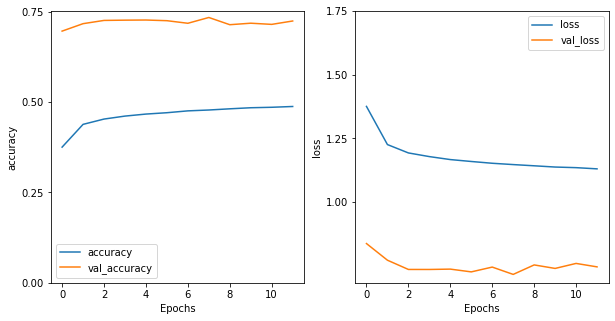

In [17]:
# Plots the Epochs va Accuracy Graph
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_graph(model_1, 'accuracy')
plt.yticks(np.arange(0, 1, step=0.25))

# Plots the Epochs va Accuracy Graph
plt.subplot(1,2,2)
plot_graph(model_1, 'loss')
plt.yticks(np.arange(1, 2, step=0.25))
plt.show()